In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from ls.config.loader import load_config
import IPython.display as ipd
import torch

In [3]:
# --- 1. load config ---
cfg = load_config("../configs/config.yaml")

print(cfg.keys())

dict_keys(['seed', 'dataset', 'audio', 'models', 'training', 'mlflow'])


### ICBHI Dataloader using only test set as the validation set

In [4]:
# # Regular training
from ls.data.dataloaders import build_dataloaders


train_loader, test_loader = build_dataloaders(cfg.dataset, cfg.audio)

[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)
[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)


/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https:/

[ICBHI] Extracted 4142 respiratory cycles from 539 recordings
[ICBHI] Input spectrogram shape: (997, 128, 1)
[ICBHI] 4142 cycles (base cycles only, aug handled dynamically)
  Class 0: 2063 (49.8%)
  Class 1: 1215 (29.3%)
  Class 2: 501 (12.1%)
  Class 3: 363 (8.8%)
[ICBHI] Active waveform augmentations: Loudness
[ICBHI] Active spectrogram augmentations: SpecAugment
[ICBHI] Expected P(augmented) ≈ 0.44 (~1822/4142 per epoch)


/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https:/

[ICBHI] Extracted 2756 respiratory cycles from 381 recordings
[ICBHI] Input spectrogram shape: (997, 128, 1)
[ICBHI] 2756 cycles (base cycles only, aug handled dynamically)
  Class 0: 1579 (57.3%)
  Class 1: 649 (23.5%)
  Class 2: 385 (14.0%)
  Class 3: 143 (5.2%)
[ICBHI] No waveform augmentations
[ICBHI] No spectrogram augmentations


In [5]:
for batch in train_loader:
    print(batch["input_values"].shape, batch["label"].shape, batch["filename"])
    break

torch.Size([8, 1, 128, 1024]) torch.Size([8]) ['158_1p3_Pl_mc_AKGC417L', '192_2b2_Al_mc_LittC2SE', '221_2b3_Lr_mc_LittC2SE', '166_1p1_Pl_sc_Meditron', '130_1p4_Lr_mc_AKGC417L', '141_1b1_Pr_mc_LittC2SE', '138_2p2_Ll_mc_AKGC417L', '156_5b3_Lr_mc_AKGC417L']


Inspecting sample index 5 in the batch
Keys: dict_keys(['input_values', 'labels', 'audio', 'label', 'filename', 'cycle_index', 'duration', 'start_time', 'end_time', 'crackle', 'wheeze', 'fbank', 'aug_audio', 'aug_fbank'])
Filename: 141_1b1_Pr_mc_LittC2SE
Cycle index: tensor(1)
Label: tensor(2)
Duration: tensor(5.7420, dtype=torch.float64)
Start-End: tensor(3.2220, dtype=torch.float64) - tensor(8.9640, dtype=torch.float64)
Crackle/Wheeze: tensor(0) tensor(1)
Waveform shape: torch.Size([1, 160000])
Mel image shape: torch.Size([1, 128, 1024])


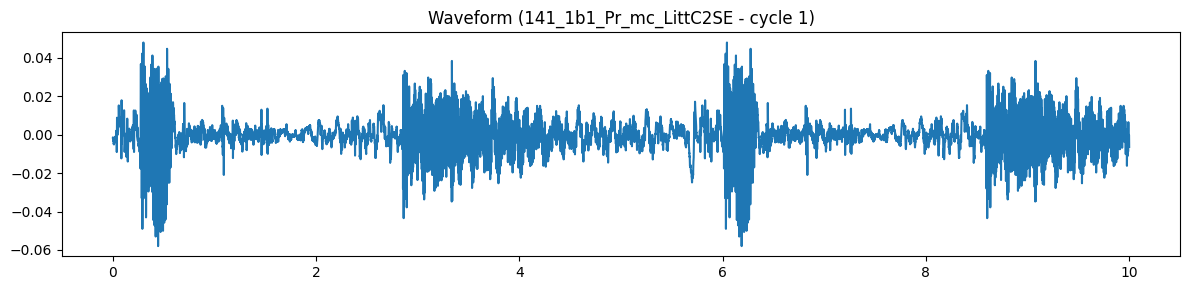

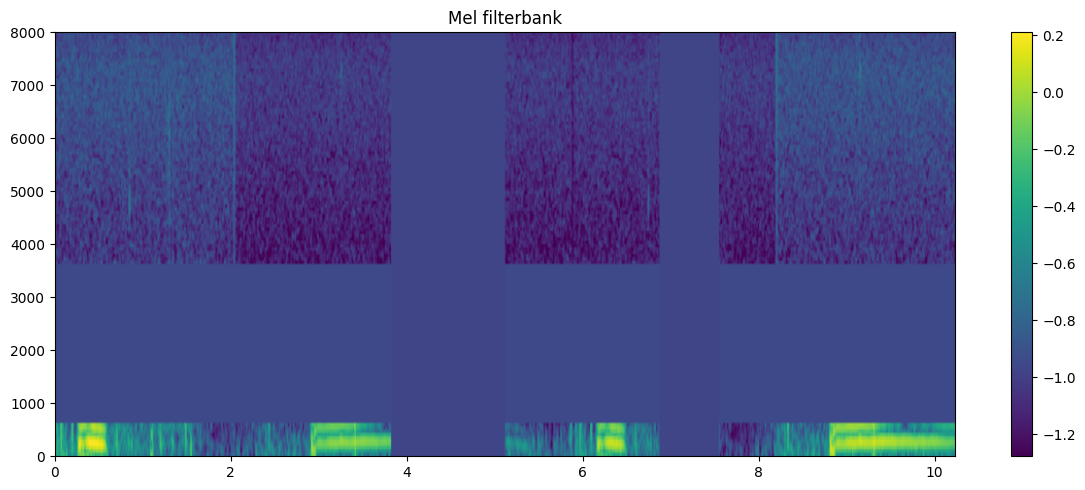

In [15]:
# --- Inspect one sample ---
idx = torch.randint(cfg.dataset.batch_size, (1,)).item()
print(f"Inspecting sample index {idx} in the batch")
print("Keys:", batch.keys())
print("Filename:", batch["filename"][idx])
print("Cycle index:", batch["cycle_index"][idx])
print("Label:", batch["label"][idx])
print("Duration:", batch["duration"][idx])
print("Start-End:", batch["start_time"][idx], "-", batch["end_time"][idx])
print("Crackle/Wheeze:", batch["crackle"][idx], batch["wheeze"][idx])
# print(sample["aug_audio"].shape, sample["aug_fbank"].shape, sample["audio"].shape, sample["fbank"].shape)
print("Waveform shape:", batch["audio"][idx].shape)
print("Mel image shape:", batch["input_values"][idx].shape)
# print(f"Waveform augmented: {not tensors_equal(batch['audio'][idx].view(-1), batch['aug_audio'][idx].view(-1))}")
# print(f"Mel augmented: {not tensors_equal(batch['fbank'][idx].view(-1), batch['aug_fbank'][idx].view(-1))}")

# --- 4. Plot waveform ---
waveform = batch["audio"][idx].squeeze().numpy()
plt.figure(figsize=(12, 3))
plt.plot(np.arange(waveform.shape[0]) / cfg.audio.sample_rate, waveform)
plt.title(f"Waveform ({batch['filename'][idx]} - cycle {batch['cycle_index'][idx]})")
plt.tight_layout()
plt.show()

# --- 5. Plot mel spectrogram ---
mel = batch["input_values"][idx].squeeze(0) # [freq, time] for imshow
freq_axis = np.linspace(0, cfg.audio.sample_rate // 2, mel.shape[0])
time_axis = np.arange(mel.shape[1]) * cfg.audio.frame_shift / 1000  # in seconds
plt.figure(figsize=(12, 5))
plt.imshow(mel, origin="lower", aspect="auto", extent=[0, time_axis[-1], 0, freq_axis[-1]], cmap="viridis")
plt.title("Mel filterbank")
plt.colorbar()
plt.tight_layout()
plt.show()

ipd.Audio(waveform, rate=cfg.audio.sample_rate)  # listen to the sound

In [153]:
epochs = cfg.training.epochs
initial_wd = float(cfg.training.optimizer.weight_decay)
final_wd = float(cfg.training.optimizer.final_weight_decay)
cfg.training.optimizer.lr = 3e-4
lr = float(cfg.training.optimizer.lr)

epochs, initial_wd, final_wd, lr

(100, 0.05, 0.0, 0.0003)

In [154]:
cfg.training.scheduler.type = "cosine_warmup" # options: none, cosine, cosine_warmup, reduce_on_plateau, cosine_warmup_restarts

In [161]:
import torch.optim as optim

optimizer = optim.AdamW(
    ast_mdl.parameters(),
    lr=lr,
    weight_decay=initial_wd,
)

In [162]:
from ls.engine.scheduler import build_scheduler

scheduler = build_scheduler(cfg.training.scheduler, cfg.training.epochs, optimizer)

In [163]:
optimizer.param_groups[0]["lr"]

3e-08

In [164]:
cfg.training.scheduler.start_linear_warmup, cfg.training.scheduler.end_linear_warmup

('1e-4', 1)

In [165]:
cfg.training.lr

0.0003

3.0026999999999996e-05
6.002399999999999e-05
9.002099999999998e-05
0.00012001799999999999
0.000150015
0.000180012
0.00021000900000000001
0.00024000600000000002
0.00027000300000000005
0.0003


/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


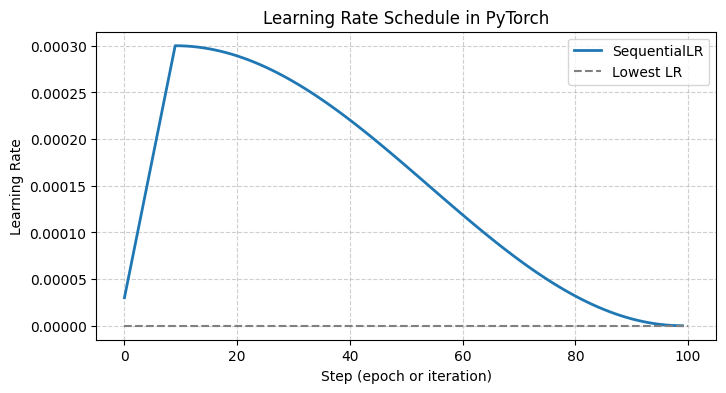

In [166]:
lrs = [] # optimizer.param_groups[0]["lr"]

for epoch in range(cfg.training.epochs):
    optimizer.step()
    scheduler.step()              # update LR according to schedule
    current_lr = optimizer.param_groups[0]['lr']
    if epoch < 10:
        print(current_lr)
    lrs.append(current_lr)

# --------------------------------------------------------
# 3. Plot the learning rate evolution
# --------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(range(cfg.training.epochs), lrs, label=scheduler.__class__.__name__, lw=2)
plt.hlines(1e-8, 0, cfg.training.epochs, colors="gray", linestyles="--", label="Lowest LR")
plt.xlabel("Step (epoch or iteration)")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule in PyTorch")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


In [3]:
from ls.models.ast import ASTModel

In [4]:
ast_mdl = ASTModel(
    input_tdim=cfg.dataset.w,
    model_size='base384',
    verbose=True,
    backbone_only=False,
    dropout_p=0.0,
    audioset_pretrain=True,
    audioset_ckpt_path="/home/AIoT04/Dev/pretrained_models/audioset_10_10_0.4593.pth"
)

NameError: name 'cfg' is not defined

In [2]:
print(ast_mdl)

NameError: name 'ast_mdl' is not defined

In [15]:
print(batch["input_values"].shape) # (B, 1, freq, time)

torch.Size([8, 1, 128, 512])


In [16]:
logits = ast_mdl(batch["input_values"])
print("Logits shape:", logits.shape)  # [B, num_classes]

Logits shape: torch.Size([8, 4])


## Or Using Hugging Face's

In [ ]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification
from datasets import load_dataset
import torch

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

print(model)
print(feature_extractor)